In [21]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from utils import *


In [22]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using cuda


In [23]:
source_path = "../Data/Augmentation/Apple"
training_path = "../train_data/Apple"
testing_path = "../test_data/Apple"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting Apple_scab
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Black_rot
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Cedar_apple_rust
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Healthy
[Training Samples:1151, Testing Samples:494]   Original Samples:1645
---------------------
Finish splitting No_leaves
[Training Samples:800, Testing Samples:343]   Original Samples:1143
---------------------
Total Training Samples: 4051, Testing Samples: 1737, Total Samples: 5788


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


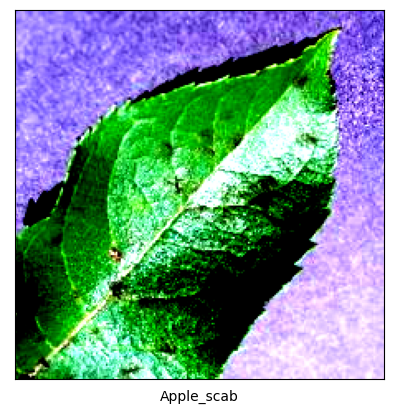

In [24]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [25]:
batch_size = 64
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 3241
Length of Validation Data : 810


(w - F + 2P)/S + 1

### EfficientNet B0 Model

In [26]:
efficient_model = load_efficient_net().to(device)

num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(efficient_model, "../Models/apple_efficient_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6861 | train_acc: 0.8613 | train_f1: 0.8608 | val_loss: 0.2569 | val_acc: 0.9717 | val_f1: 0.9716 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.2037 | train_acc: 0.9775 | train_f1: 0.9775 | val_loss: 0.1422 | val_acc: 0.9760 | val_f1: 0.9753 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1306 | train_acc: 0.9844 | train_f1: 0.9843 | val_loss: 0.0959 | val_acc: 0.9880 | val_f1: 0.9877 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1027 | train_acc: 0.9827 | train_f1: 0.9827 | val_loss: 0.0779 | val_acc: 0.9916 | val_f1: 0.9914 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0831 | train_acc: 0.9882 | train_f1: 0.9883 | val_loss: 0.0665 | val_acc: 0.9904 | val_f1: 0.9901 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0723 | train_acc: 0.9896 | tra

In [27]:
# accuracy for efficientNet b0
efficient_model = torch.load("../Models/apple_efficient_model.pt")
efficient_report = test_run(efficient_model, test_dl, device, batch_size, classes)
print(efficient_report)

                  precision    recall  f1-score   support

      Apple_scab       0.97      0.97      0.97       300
       Black_rot       0.99      0.99      0.99       300
Cedar_apple_rust       1.00      1.00      1.00       300
         Healthy       0.99      0.99      0.99       494
       No_leaves       1.00      1.00      1.00       343

        accuracy                           0.99      1737
       macro avg       0.99      0.99      0.99      1737
    weighted avg       0.99      0.99      0.99      1737



### MobileNetV2 Model

In [28]:
mobile_model = load_mobile_net().to(device)

mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.001)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(mobile_model, "../Models/apple_mobile_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7984 | train_acc: 0.8271 | train_f1: 0.8266 | val_loss: 0.3712 | val_acc: 0.9627 | val_f1: 0.9630 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.2688 | train_acc: 0.9752 | train_f1: 0.9750 | val_loss: 0.1976 | val_acc: 0.9880 | val_f1: 0.9877 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1739 | train_acc: 0.9767 | train_f1: 0.9769 | val_loss: 0.1392 | val_acc: 0.9892 | val_f1: 0.9889 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1267 | train_acc: 0.9847 | train_f1: 0.9846 | val_loss: 0.1107 | val_acc: 0.9892 | val_f1: 0.9889 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0987 | train_acc: 0.9876 | train_f1: 0.9877 | val_loss: 0.0923 | val_acc: 0.9916 | val_f1: 0.9914 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0866 | train_acc: 0.9876 | tra

In [29]:
# MobileNet V2 accuracy
mobile_model = torch.load("../Models/apple_mobile_model.pt")
mobile_report = test_run(mobile_model, test_dl, device, batch_size, classes)
print(mobile_report)

                  precision    recall  f1-score   support

      Apple_scab       0.98      0.95      0.96       300
       Black_rot       0.99      0.99      0.99       300
Cedar_apple_rust       0.98      1.00      0.99       300
         Healthy       0.98      0.99      0.98       494
       No_leaves       1.00      0.99      1.00       343

        accuracy                           0.99      1737
       macro avg       0.99      0.98      0.99      1737
    weighted avg       0.99      0.99      0.99      1737



### Predicting Single Image

In [30]:
from PIL import Image
test_img_path = "/Users/afflatus/Documents/UoM_MSc/Diss/train_data/Black_rot/image (12).JPG"

img = Image.open(test_img_path)


img1 = transformation(img)

display_img(img1, predict(mobile_model, test_img_path, device), classes)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/afflatus/Documents/UoM_MSc/Diss/train_data/Black_rot/image (12).JPG'